In [1]:
import numpy as np
import healsparse as hsp
import healpy as hp
import matplotlib.pyplot as plt
import sys
%matplotlib inline

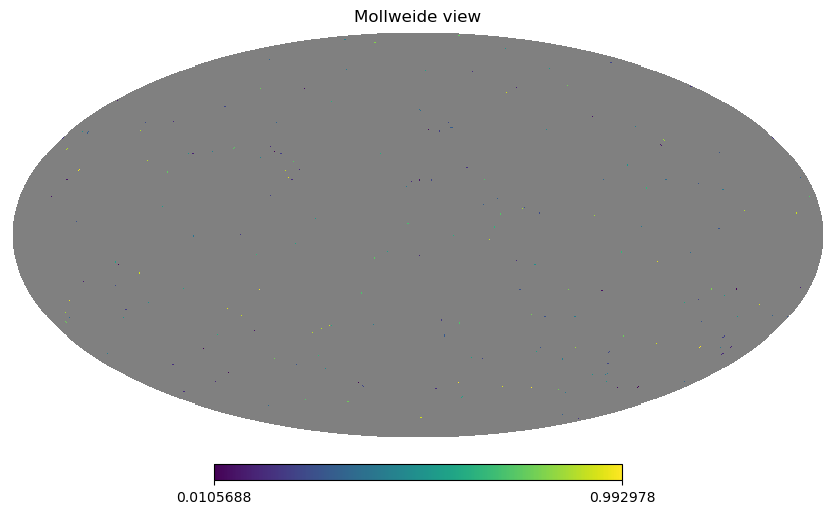

In [4]:
# These values are going to control the resolution of the maps
nside_coverage = 32 # This is going to control the resolution of the "low-resolution map" that tells us which pixels are covered
nside_sparse = 128 # This is going to control the resolution of the "high-resolution" map that contains the information that we care about
n_pop = 200
ra_rnd = 360.0*np.random.random(size=n_pop)
dec_rnd = -90.0 + 180.0*np.random.random(size=n_pop)
value_rnd = np.random.random(size=n_pop)
hp_aux = np.zeros(hp.nside2npix(nside_sparse)) + hp.UNSEEN # Empty pixels for `HealSparse` are marked by `hp.UNSEEN`
hp_aux[hp.ang2pix(nside_sparse, np.radians(90 - dec_rnd), np.radians(ra_rnd), nest=True)] = value_rnd
hp.mollview(hp_aux)

In [5]:
# Now let's create the `HealSparseMap`
hsp_map = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=hp_aux)

In [6]:
# Now let's check the size savings
print('Size of Original HEALPix map [KB] ', sys.getsizeof(hp_aux)/1024.)
print('Size of HealSparse Map [KB]:' ,sys.getsizeof(hsp_map._sparse_map)/1024.)
print('Memory footprint reduction factor:', int(1.0*sys.getsizeof(hp_aux)/sys.getsizeof(hsp_map._sparse_map)))
# We reduce a factor of 62!! But this is mostly due because the map is very sparse

Size of Original HEALPix map [KB]  1536.109375
Size of HealSparse Map [KB]: 24.609375
Memory footprint reduction factor: 62


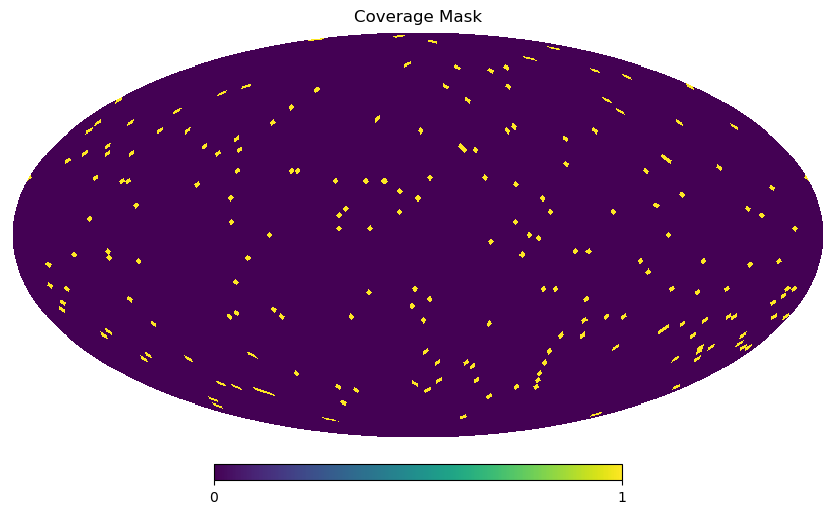

In [7]:
hsp_mask = hsp_map.coverage_mask
hp.mollview(hsp_mask, title='Coverage Mask')

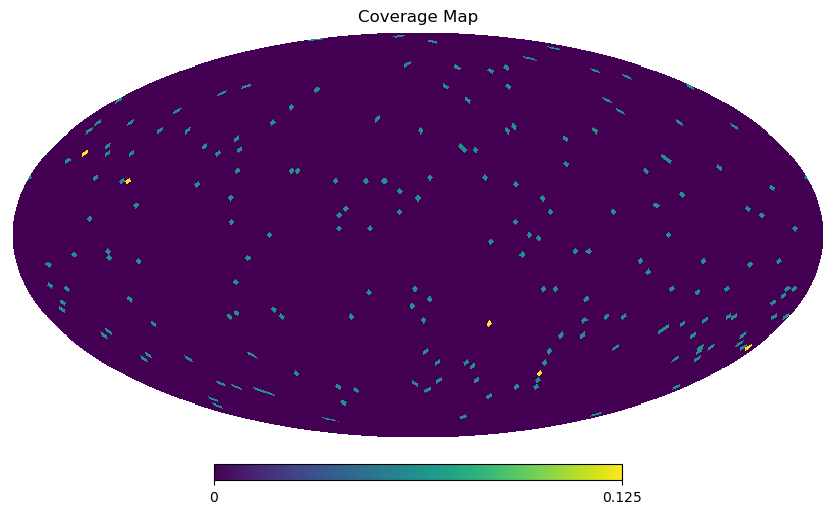

In [15]:
hsp_cov_map = hsp_map.coverage_map
hp.mollview(hsp_cov_map, title='Coverage Map')

In [16]:
# Points to probe
test_ra = 360*np.random.random(size=10)
test_dec = -90 + 180*np.random.random(size=10)
# Values to recover
test_values = hsp_map.get_values_pos(test_ra, test_dec, lonlat=True)
# There's also the possiblity of getting them from the theta/phi coordinates:
test_values_2 = hsp_map.get_values_pos(np.radians(90 - test_dec), np.radians(test_ra), lonlat=False)
print('Are all the pixel values the same using both methods?', np.allclose(test_values, test_values_2))

Are all the pixel values the same using both methods? True


In [17]:
test_px_num = hp.ang2pix(hsp_map._nside_sparse, np.radians(90 - test_dec), np.radians(test_ra), nest=True)
test_values_2 = hsp_map.get_values_pix(test_px_num)
print('Are all the pixel values the same using both methods?', np.allclose(test_values, test_values_2))

Are all the pixel values the same using both methods? True


In [19]:
valid_pixels_indices = hsp_map.valid_pixels
print(valid_pixels_indices) # These are the indices of the HEALPixels with nside=1024 that have been observed

[   208    787   1317   2624   5589   6739   8505   8620   9379   9628
  11663  15216  15489  15956  16121  16453  18181  21630  21939  22320
  24556  26678  27251  29882  32188  32619  32718  33000  34909  35559
  36513  36600  36812  37366  37616  37873  40448  41552  44629  44903
  45952  46581  47971  48014  48687  48921  48990  49051  49054  51564
  53175  53588  55923  57567  58703  58712  58850  59814  63317  63492
  64338  64486  64605  64646  64724  65271  65279  65284  67145  68359
  69739  70714  74079  74756  75244  76493  79574  80291  81084  82109
  82992  84496  84659  85195  86160  87872  89560  90886  93298  93391
  94273  97648  98702  99050 101075 103245 108307 109139 109183 110438
 111359 112052 112411 114369 114791 114979 115137 116671 116917 121267
 126425 128965 130054 130969 131119 131135 131293 131432 131741 131773
 132231 133413 135221 136967 137797 138216 139188 139341 140314 142721
 143302 144881 146610 146809 146956 147456 147491 147603 147624 147916
 14795

Pixel resolution: 0.46 deg


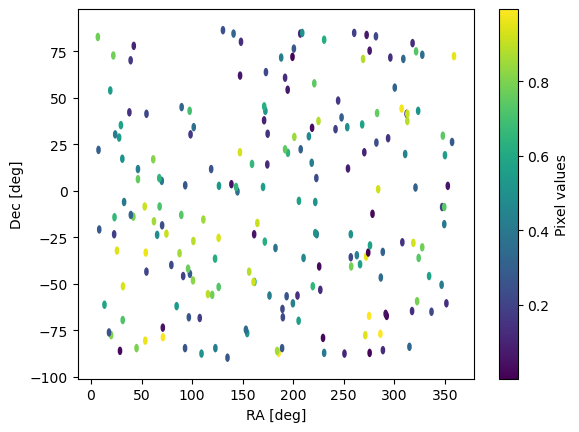

In [20]:
ra_valid, dec_valid = hsp_map.valid_pixels_pos(lonlat=True)
# Let's retrieve the values of the pixels at these locations. There's an alternative way to do this
hsp_map_values = hsp_map.get_values_pos(ra_valid, dec_valid, lonlat=True)

# Another option to retrieve the values of the map can be instead the line below:
#hsp_map_values = hsp_map.get_values_pix(hsp_map.valid_pixels)

size = 1./60*hp.nside2resol(nside_sparse, arcmin=True) # Get the resolution of the pixel
print('Pixel resolution: %.2f deg' % (size))
# Let's take a look, approximating each pixel as Circles with radius = resolution/2
# We will draw circles 10 times larger than they should so we can see them in this map
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
# This visualization is not accurate but it helps
patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(ra_valid, dec_valid, 10*size/2)]
collection = PatchCollection(patches)
collection.set_array(np.asarray(hsp_map_values))
f, ax = plt.subplots(1,1)
ax.add_collection(collection)
ax.autoscale_view()
plt.sci(collection)
plt.colorbar(label='Pixel values')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]');

In [21]:
# We are going to create 3 maps: one with galaxy overdensity, another with number of stars (integer), and one with sky-brightness
dtype = [('gal_delta','f8'),('star_num','i4'),('sky_brightness','f4')]
npop = 10000 # We are going to populate 10000 pixels
ra_rnd = 360*np.random.random(size=npop)
dec_rnd = -90 + 180.0*np.random.random(size=npop)
nside_sparse = 512 # This is the resolution for our sparse map
nside_coverage = 32 # This is the resolution of our coverage map
# We are going to fill up the pixels corresponding to the positions above 
px_rnd = hp.ang2pix(nside_sparse, np.radians(90 - dec_rnd), np.radians(ra_rnd), nest=True)
# We find the pixels that aren't repeated
px_rnd = np.unique(px_rnd)
npop = len(px_rnd)
# Create an empty array
test_arr = np.zeros(npop, dtype=dtype)
# Fill up the arrays with random values
test_arr['gal_delta'] = -1 + 10*np.random.random(npop)
test_arr['star_num'] = np.random.randint(low=0, high=10, size=npop)
test_arr['sky_brightness'] = 3000 + 10000*np.random.random(size=npop)
hsp_recarray = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, dtype=dtype, primary='gal_delta') # A primary key should be chosen! This marks our "primary" map
hsp_recarray.update_values_pix(px_rnd, test_arr)

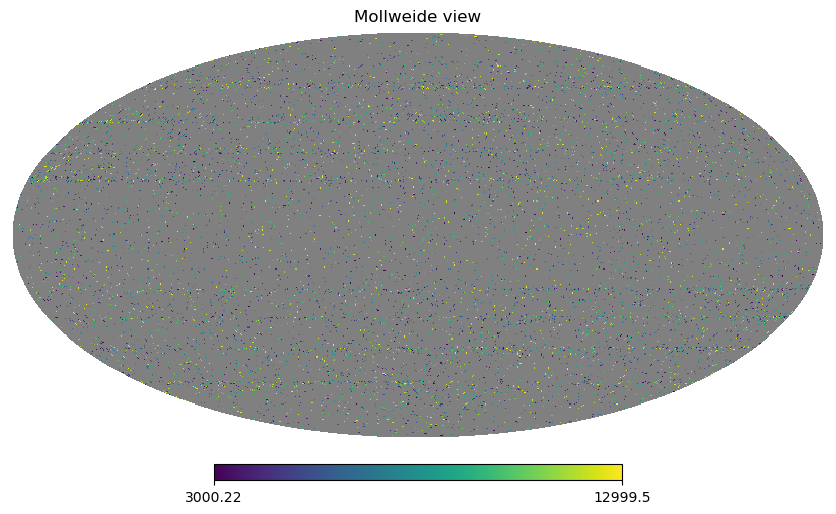

In [22]:
rec_hp = hsp_recarray.generate_healpix_map(nside=128, key='sky_brightness')
hp.mollview(rec_hp)

In [ ]:
print(hsp_recarray._sparse_map.dtype.fields)

{'gal_delta': (dtype('float64'), 0), 'star_num': (dtype('int32'), 8), 'sky_brightness': (dtype('float32'), 12)}
